<a href="https://colab.research.google.com/github/enjoyPG/2023Gifted/blob/main/students/jwoo428/pytorch/14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 불러오기

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/data/img_align_celeba.zip" "."
!unzip "./img_align_celeba.zip" -d "./GAN/"

# 학습에 사용할 데이터셋 정의

In [ ]:
import glob
import torchvision.transforms as tf

from torch.utils.data.dataset import Dataset
from PIL import Image


class CelebA(Dataset):
   def __init__(self):
       self.imgs = glob.glob("./GAN/img_align_celeba/*.jpg")
      
       # ❶ 정규화에 이용할 평균과 공분산
       mean_std = (0.5, 0.5, 0.5)
      
       # ❷ 입력용 이미지 생성
       self.low_res_tf = tf.Compose([
           tf.Resize((32, 32)),
           tf.ToTensor(),
           tf.Normalize(mean_std, mean_std)
       ])

       # ❸ 정답용 이미지 생성
       self.high_res_tf = tf.Compose([
           tf.Resize((64, 64)),
           tf.ToTensor(),
           tf.Normalize(mean_std, mean_std)
       ])
   def __len__(self):
       return len(self.imgs) # ❶ 

   def __getitem__(self, i):
       img = Image.open(self.imgs[i])
      
       # ❷ 저화질 이미지는 입력으로
       img_low_res = self.low_res_tf(img)
       # ❸ 고화질 입력은 정답으로
       img_high_res = self.high_res_tf(img)

       return [img_low_res, img_high_res]

# SRGAN 기본 합성곱 블록

In [ ]:
import torch.nn as nn


class ResidualBlock(nn.Module):
   def __init__(self, in_channels, out_channels):
       super(ResidualBlock, self).__init__()
      
       # 생성자의 구성요소 정의
       self.layers = nn.Sequential(
           nn.Conv2d(in_channels, out_channels, 
                     kernel_size=3, stride=1, padding=1),
           nn.BatchNorm2d(out_channels),
           nn.PReLU(),
           nn.Conv2d(out_channels, out_channels, 
                     kernel_size=3, stride=1, padding=1),
           nn.BatchNorm2d(out_channels)
       )

   def forward(self, x):
       x_ = x
       x = self.layers(x)
      
       # 합성곱층을 거친 후 원래의 입력 텐서와 더해줌
       x = x_ + x

       return x

# 업샘플링층 정의

In [ ]:
# 업샘플링층의 정의
class UpSample(nn.Sequential):
   def __init__(self, in_channels, out_channels):
       super(UpSample, self).__init__(
           nn.Conv2d(in_channels, out_channels, 
                     kernel_size=3, stride=1, padding=1),
           nn.PixelShuffle(upscale_factor=2),
           nn.PReLU()
       )

# 생성자 정의

In [ ]:
class Generator(nn.Module):
   def __init__(self):
       super(Generator, self).__init__()

       # ➊ 첫 번째 합성곱층
       self.conv1 = nn.Sequential(
           nn.Conv2d(3, 64, 
                     kernel_size=9, stride=1, padding=4),
           nn.PReLU()
       )
      
       # ➋ 합성곱 블록
       self.res_blocks = nn.Sequential(
           ResidualBlock(in_channels=64, out_channels=64),
           ResidualBlock(in_channels=64, out_channels=64),
           ResidualBlock(in_channels=64, out_channels=64),
       )
      
       self.conv2 = nn.Conv2d(64, 64, 
                           kernel_size=3, stride=1, padding=1)
       self.bn2 = nn.BatchNorm2d(64)
      
       # ➌ 업샘플링층
       self.upsample_blocks = nn.Sequential(
           UpSample(in_channels=64, out_channels=256)
       )

       # ➍ 마지막 합성곱층
       self.conv3 = nn.Conv2d(64, 3, 
                           kernel_size=9, stride=1, padding=4)
   def forward(self, x):
       # ➊ 첫 번째 합성곱층
       x = self.conv1(x)
       # ➋ 합성곱 블록을 거친 결과와 더하기 위해
       # 값을 저장
       x_ = x

       # ➌ 합성곱 블록
       x = self.res_blocks(x)
       x = self.conv2(x)
       x = self.bn2(x)
       # ➍ 합성곱 블록과 첫 번째 합성곱층의 결과를 더함
       x = x + x_

       # ➎ 업샘플링 블록
       x = self.upsample_blocks(x)
       # ➏ 마지막 합성곱층
       x = self.conv3(x)

       return x

# 감별자 기본 블록 정의

In [ ]:
# 한 번 거칠 때마다 이미지 크기가 절반이 되는 합성곱층
class DiscBlock(nn.Module):
   def __init__(self, in_channels, out_channels):
       super(DiscBlock, self).__init__()
      
       self.layers = nn.Sequential(
           nn.Conv2d(in_channels, out_channels, 
                     kernel_size=3, stride=2, padding=1),
           nn.BatchNorm2d(out_channels),
           nn.LeakyReLU()
       )

   def forward(self, x):
       return self.layers(x)

# 감별자 정의

In [ ]:
class Discriminator(nn.Module):
   def __init__(self):
       super(Discriminator, self).__init__()
      
       self.conv1 = nn.Sequential(
           nn.Conv2d(3, 64, 
                     kernel_size=3, stride=1, padding=1),
           nn.LeakyReLU()
       )

       self.blocks = DiscBlock(in_channels=64, out_channels=64)

       self.fc1 = nn.Linear(65536, 1024)
       self.activation = nn.LeakyReLU()
       self.fc2 = nn.Linear(1024, 1)
       self.sigmoid = nn.Sigmoid()

   def forward(self, x):
       # ➊ 컨볼루션 층
       x = self.conv1(x)
       x = self.blocks(x)
      
       # ➋ 1차원으로 펼쳐줌
       x = torch.flatten(x, start_dim=1)
      
       # ➌ 이진분류 단계
       x = self.fc1(x)
       x = self.activation(x)
       x = self.fc2(x)
       x = self.sigmoid(x)

       return x

# 특징 추출기 정의

In [ ]:
import torch
from torchvision.models.vgg import vgg19


# VGG19 특징 추출기
class FeatureExtractor(nn.Module):
   def __init__(self):
       super(FeatureExtractor, self).__init__()
       # ➊ 사전 학습된 vgg19 모델 정의
       vgg19_model = vgg19(pretrained=True)

       # ➋ VGG19의 9개 층만을 이용
       self.feature_extractor = nn.Sequential(
           *list(vgg19_model.features.children())[:9])

   def forward(self, img):
       return self.feature_extractor(img)

# 학습에 필요한 요소 정의

In [ ]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

# ➊ 데이터로더 정의
dataset = CelebA()
batch_size = 8
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ➋ 생성자와 감별자 정의
G = Generator().to(device)
D = Discriminator().to(device)
feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval()


# ➌ 생성자와 감별자의 최적화 정의
G_optim = Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

# 학습 루프 정의

In [ ]:
for epoch in range(1):
   iterator = tqdm.tqdm(loader)

   for i, (low_res, high_res) in enumerate(iterator):
       # ❶기울기의 초기화
       G_optim.zero_grad()
       D_optim.zero_grad()

       # ➋ 진짜 이미지와 가짜 이미지의 정답
       label_true = torch.ones(batch_size, dtype=torch.float32).to(device)
       label_false = torch.zeros(batch_size, dtype=torch.float32).to(device)

       # ➌ 생성자 학습
       fake_hr = G(low_res.to(device))
       GAN_loss = nn.MSELoss()(D(fake_hr), label_true)
       # CNN 특징추출기로부터 추출된 특징의 비교
       # ➊ 가짜 이미지의 특징 추출
       fake_features = feature_extractor(fake_hr)
       # ➋ 진짜 이미지의 특징 추출
       real_features = feature_extractor(high_res.to(device))
       # ➌ 둘의 차이 비교
       content_loss = nn.L1Loss()(fake_features, real_features)
       # 생성자의 손실 정의
       loss_G = content_loss + 0.001*GAN_loss
       loss_G.backward()
       G_optim.step()
       # 감별자 학습
       # ➊ 진짜 이미지의 손실
       real_loss = nn.MSELoss()(D(high_res.to(device)), label_true)
       # ➋ 가짜 이미지의 손실
       fake_loss = nn.MSELoss()(D(fake_hr.detach()), label_false)
       # ➌ 두 손실의 평균값을 최종 오차로 설정
       loss_D = (real_loss + fake_loss) / 2
       # ➍ 오차 역전파
       loss_D.backward()
       D_optim.step()

       iterator.set_description(
           f"epoch:{epoch} G_loss:{GAN_loss} D_loss:{loss_D}")

torch.save(G.state_dict(), "SRGAN_G.pth")
torch.save(D.state_dict(), "SRGAN_D.pth")

  0%|          | 0/25325 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch:0 G_loss:1.0 D_loss:0.0: 100%|█████████▉| 25323/25325 [41:27<00:00, 10.36it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch:0 G_loss:1.0 D_loss:0.0: 100%|██████████| 25325/25325 [41:28<00:00, 10.18it/s]


# 모델 성능 평가하기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


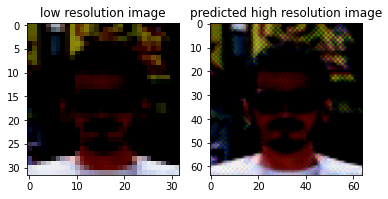

In [ ]:
import matplotlib.pyplot as plt

G.load_state_dict(torch.load("SRGAN_G.pth", map_location=device))

with torch.no_grad():
   low_res, high_res = dataset[10]
  
   # ➊ 생성자의 입력
   input_tensor = torch.unsqueeze(low_res, dim=0).to(device)
  
   # ➋ 생성자가 생성한 고화질 이미지
   pred = G(input_tensor)
   pred = pred.squeeze()
   pred = pred.permute(1, 2, 0).cpu().numpy()
  
   # ➌ 저화질 이미지의 채널 차원을 가장 마지막으로
   low_res = low_res.permute(1, 2, 0).numpy()
  
   # ➍ 저화질 입력과 생성자가 만든 고화질 이미지의 비교
   plt.subplot(1, 2, 1)
   plt.title("low resolution image")
   plt.imshow(low_res)
   plt.subplot(1, 2, 2)
   plt.imshow(pred)
   plt.title("predicted high resolution image")
   plt.show()